In [245]:
import mysql.connector as mysql
import numpy as np
import base64
import PIL
from PIL import Image as Image
#from IPython.display import Image
#import urllib.parse
import io
import re

In [246]:
mydb = mysql.connect(
    host="127.0.0.1",
    port=49157,
    user="root",
    password="datascience",
    database="racer")


In [247]:
dbcursor = mydb.cursor()


In [252]:
def showURI(imageuri):
    imgstr = re.search(r'base64,(.*)', imageuri).group(1)
    image_bytes = io.BytesIO(base64.b64decode(imgstr))
    im = Image.open(image_bytes)
    display(im)
    #return im
    #arr = np.array(im)[:,:,0]

def imageToNp(im):
    arr = np.array(im)[:,:,0]
    return arr

def uriToNP(imageuri):
    imgstr = re.search(r'base64,(.*)', imageuri).group(1)
    image_bytes = io.BytesIO(base64.b64decode(imgstr))
    im = Image.open(image_bytes)
    arr = np.array(im)[:,:,0]
    return arr

def showNP(a, fmt='png'):
    a = np.uint8(a)
    f = io.StringIO()
    display(PIL.Image.fromarray(a))
    #IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [253]:
dbcursor.execute("SELECT * FROM images")
results = dbcursor.fetchall()


In [254]:
def process(layer, batch, processor):
    dbcursor = mydb.cursor()
    dbcursor.execute(f"SELECT * FROM images WHERE layerid = '{layer}' and batchid = '{batch}' LIMIT 5;")
    newlayer = layer + 1
    lasttime=0
    lastimage_np = None
    results = dbcursor.fetchall()
    print(f"num rows to process: {len(results)}")
    for result in results:
        imageuri = result[7]
        time = result[1]
        position = result[2]
        velocity = result[3]
        rotation = result[4]
        tdelta = time - lasttime
        lasttime = time
        
        image_np = uriToNP(imageuri)
        if lastimage_np is not None:
            print(tdelta)
            image_diff = image_np- lastimage_np
            showNP(image_diff)
            print(image_diff.shape)
        lastimage_np = image_np
        print(image_np.shape)

num rows to process: 5
(50, 50)
22


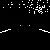

(50, 50)
(50, 50)
14


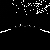

(50, 50)
(50, 50)
16


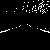

(50, 50)
(50, 50)
17


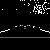

(50, 50)
(50, 50)


In [255]:
process(0,0,None)

(5341, 1625319102985, 87.61086760040557, 121.99895192306394, -0.029241084849860682, 0)
1625319102985 ms since last frame, fps: 6.152637953762049e-10


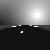

(5342, 1625319103002, 85.91750988109887, 122.0270540134896, -0.029211738671615528, 0)
17 ms since last frame, fps: 58.8235294117647


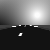

(5343, 1625319103018, 84.24750848268191, 122.05497854571864, -0.029182577890784156, 0)
16 ms since last frame, fps: 62.5


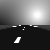

(5344, 1625319103034, 82.60069571981724, 122.08272662086145, -0.029054173154473367, 0)
16 ms since last frame, fps: 62.5


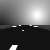

(5345, 1625319103051, 80.98517265066342, 122.11029933060723, -0.02862422387373008, 0)
17 ms since last frame, fps: 58.8235294117647


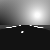

In [217]:
lasttime=0
for result in results[1200:1205:]:
    imageuri = result[7]
    time = result[1]
    tdelta = time - lasttime
    print(result[:6])
    print(f"{tdelta} ms since last frame, fps: {1000/tdelta}")
    showURI(imageuri)
    lasttime = time
    #print(result[1])

In [89]:
#im = Image(url=imageuri)
#response = urllib.request.urlopen(imageuri)

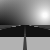

In [91]:
im

In [92]:
arr

array([[147, 147, 143, ..., 178, 176, 176],
       [142, 139, 138, ..., 181, 180, 178],
       [135, 135, 131, ..., 185, 183, 182],
       ...,
       [178, 178, 178, ..., 178, 178, 178],
       [178, 178, 178, ..., 178, 178, 178],
       [178, 178, 178, ..., 178, 178, 178]], dtype=uint8)

In [93]:
arr.shape

(50, 50)

In [56]:
data.shape

()

In [57]:
data

array(<IPython.core.display.Image object>, dtype=object)